/mnt/workspace/miniconda3/envs/ebrnn/lib/python3.6/site-packages/ipykernel_launcher.py:43: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


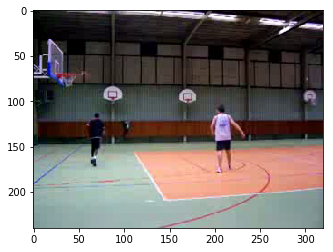

In [12]:
import sys
import os
from os import path
import time
from time import sleep

import tensorflow as tf
import numpy as np
# import cv2
# import matplotlib.pyplot as plt
import pylab as plt

from tqdm import tqdm, trange, tqdm_notebook, tnrange
import glob
import time
import pandas as pd
import h5py
import pickle as pkl
import subprocess as sp

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = '0'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

command = [ 'ffmpeg',
#            '-i', '/mnt/workspace/datasets/UCF-101/BreastStroke/v_BreastStroke_g01_c01.avi'
#            '-i', '/mnt/workspace/datasets/UCF-101/BreastStroke/v_BreastStroke_g01_c01.avi',
#             '-i', '/mnt/workspace/datasets/UCF-101/BasketballDunk/v_BasketballDunk_g01_c01.avi',
           '-i', '/mnt/workspace/datasets/UCF-101/Basketball/v_Basketball_g01_c03.avi',
#            '-i', '/mnt/workspace/datasets/UCF-101/Billiards/v_Billiards_g01_c01.avi',
            '-f', 'image2pipe',
            '-pix_fmt', 'rgb24',
            '-vcodec', 'rawvideo', '-']
pipe = sp.Popen(command, stdout = sp.PIPE, bufsize=10**8)
video_frames = []
while True:
    # read 420*360*3 bytes (= 1 frame)
    raw_image = pipe.stdout.read(240*320*3)
#     print(type(raw_image))
    if len(raw_image) != 240*320*3:
        break;
    # transform the byte read into a numpy array
    image =  np.fromstring(raw_image, dtype='uint8')
    image = image.reshape((240,320,3))
#     image[:,:,0] = image[:,:,0] - 123.68
#     image[:,:,1] = image[:,:,1] - 116.78
#     image[:,:,2] = image[:,:,2] - 103.94
    video_frames.append(image)
    # throw away the data in the pipe's buffer.
    pipe.stdout.flush()
#     np.shape(image)
#     plt.imshow(image)
video_frames = np.asarray(video_frames, dtype=np.uint8)
for img in video_frames[:1,:,:,:]:
    plt.figure()
    plt.imshow(img)

(240, 320, 3)
(240, 320, 3)
Tensor("Const:0", shape=(240, 320, 3), dtype=uint8)
Tensor("ResizeBilinear:0", shape=(1, 224, 224, 3), dtype=float32)
INFO:tensorflow:Restoring parameters from /mnt/workspace/models/checkpoints/vgg_16.ckpt


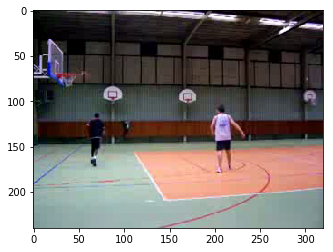

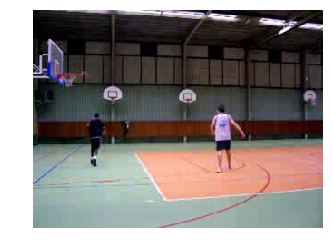

Probability 56.03% => [volleyball]
Probability 25.25% => [racket, racquet]
Probability 7.08% => [horizontal bar, high bar]
Probability 4.35% => [ping-pong ball]
Probability 1.90% => [parallel bars, bars]


In [13]:
from os import sys
slim_dir = "/mnt/workspace/models/research/slim/"
sys.path.insert(0, slim_dir)
checkpoints_dir = "/mnt/workspace/models/checkpoints/"
from matplotlib import pyplot as plt

import numpy as np
import os
import tensorflow as tf

try:
    import urllib2
except ImportError:
    import urllib.request as urllib

from datasets import imagenet
from nets import vgg
from preprocessing import vgg_preprocessing

from tensorflow.contrib import slim

means = [123.68, 116.779, 103.939]

image_size = vgg.vgg_16.default_image_size

with tf.Graph().as_default():
#     url = 'https://upload.wikimedia.org/wikipedia/commons/d/d9/First_Student_IC_school_bus_202076.jpg'
#     url = "https://cdn.images.dailystar.co.uk/dynamic/63/photos/425000/620x/Ronnie-O-Sullivan-742226.jpg"
#     image_string = urllib.urlopen(url).read()
#     print(type(image_string))
    
#     filename_queue = tf.train.string_input_producer(['/mnt/workspace/ebrnn-tf/download 1.png']) #  list of files to read
#     reader = tf.WholeFileReader()
#     key, image_string = reader.read(filename_queue)

#     img = plt.imread('/mnt/workspace/datasets/ucf101/ucf24/rgb-images/GolfSwing/v_GolfSwing_g01_c01/00001.jpg')
#     img = plt.imread('/mnt/workspace/datasets/ucf101/ucf24/rgb-images/GolfSwing/v_GolfSwing_g01_c01/00001.jpg')
#     img = plt.imread('./test.png')
    print(np.shape(img))
#     img = img[:,:,:3]
    print(np.shape(img))
    plt.imshow(img)
    image = tf.convert_to_tensor(img, dtype=tf.uint8)
    processed_images1  = tf.expand_dims(image, 0)
    print(image)
    normalized_images1 = tf.image.resize_images(processed_images1, [image_size,image_size])
    print(normalized_images1)
    channels = tf.split(axis=3, num_or_size_splits=3, value=normalized_images1)
    for j in range(3):
        channels[j] -= means[j]
    processed_images = tf.concat(axis=3, values=channels)
    
#     image = tf.image.decode_jpeg(image_string, channels=3)
#     processed_image = vgg_preprocessing.preprocess_image(image, image_size, image_size, is_training=False)
#     processed_images  = tf.expand_dims(processed_image, 0)
#     print(processed_images)
    
    # Create the model, use the default arg scope to configure the batch norm parameters.
    with slim.arg_scope(vgg.vgg_arg_scope()):
        # 1000 classes instead of 1001.
        logits, _ = vgg.vgg_16(processed_images, num_classes=1000, is_training=False)
    probabilities = tf.nn.softmax(logits)
    
    init_fn = slim.assign_from_checkpoint_fn(
        os.path.join(checkpoints_dir, 'vgg_16.ckpt'),
        slim.get_model_variables('vgg_16'))
    
    with tf.Session() as sess:
        init_fn(sess)
        np_image, probabilities = sess.run([image, probabilities])
        probabilities = probabilities[0, 0:]
        sorted_inds = [i[0] for i in sorted(enumerate(-probabilities), key=lambda x:x[1])]
        
    plt.figure()
    plt.imshow(np_image.astype(np.uint8))
    plt.axis('off')
    plt.show()
    
    names = imagenet.create_readable_names_for_imagenet_labels()
    for i in range(5):
        index = sorted_inds[i]
        # Shift the index of a class name by one. 
        print('Probability %0.2f%% => [%s]' % (probabilities[index] * 100, names[index+1]))

In [ ]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import tensorflow as tf

slim = tf.contrib.slim

_R_MEAN = 123.68
_G_MEAN = 116.78
_B_MEAN = 103.94

_RESIZE_SIDE_MIN = 256
_RESIZE_SIDE_MAX = 512


def _crop(image, offset_height, offset_width, crop_height, crop_width):
  """Crops the given image using the provided offsets and sizes.
  Note that the method doesn't assume we know the input image size but it does
  assume we know the input image rank.
  Args:
    image: an image of shape [height, width, channels].
    offset_height: a scalar tensor indicating the height offset.
    offset_width: a scalar tensor indicating the width offset.
    crop_height: the height of the cropped image.
    crop_width: the width of the cropped image.
  Returns:
    the cropped (and resized) image.
  Raises:
    InvalidArgumentError: if the rank is not 3 or if the image dimensions are
      less than the crop size.
  """
  original_shape = tf.shape(image)

  rank_assertion = tf.Assert(
      tf.equal(tf.rank(image), 3),
      ['Rank of image must be equal to 3.'])
  with tf.control_dependencies([rank_assertion]):
    cropped_shape = tf.stack([crop_height, crop_width, original_shape[2]])

  size_assertion = tf.Assert(
      tf.logical_and(
          tf.greater_equal(original_shape[0], crop_height),
          tf.greater_equal(original_shape[1], crop_width)),
      ['Crop size greater than the image size.'])

  offsets = tf.to_int32(tf.stack([offset_height, offset_width, 0]))

  # Use tf.slice instead of crop_to_bounding box as it accepts tensors to
  # define the crop size.
  with tf.control_dependencies([size_assertion]):
    image = tf.slice(image, offsets, cropped_shape)
  return tf.reshape(image, cropped_shape)


def _random_crop(image_list, crop_height, crop_width):
  """Crops the given list of images.
  The function applies the same crop to each image in the list. This can be
  effectively applied when there are multiple image inputs of the same
  dimension such as:
    image, depths, normals = _random_crop([image, depths, normals], 120, 150)
  Args:
    image_list: a list of image tensors of the same dimension but possibly
      varying channel.
    crop_height: the new height.
    crop_width: the new width.
  Returns:
    the image_list with cropped images.
  Raises:
    ValueError: if there are multiple image inputs provided with different size
      or the images are smaller than the crop dimensions.
  """
  if not image_list:
    raise ValueError('Empty image_list.')

  # Compute the rank assertions.
  rank_assertions = []
  for i in range(len(image_list)):
    image_rank = tf.rank(image_list[i])
    rank_assert = tf.Assert(
        tf.equal(image_rank, 3),
        ['Wrong rank for tensor  %s [expected] [actual]',
         image_list[i].name, 3, image_rank])
    rank_assertions.append(rank_assert)

  with tf.control_dependencies([rank_assertions[0]]):
    image_shape = tf.shape(image_list[0])
  image_height = image_shape[0]
  image_width = image_shape[1]
  crop_size_assert = tf.Assert(
      tf.logical_and(
          tf.greater_equal(image_height, crop_height),
          tf.greater_equal(image_width, crop_width)),
      ['Crop size greater than the image size.'])

  asserts = [rank_assertions[0], crop_size_assert]

  for i in range(1, len(image_list)):
    image = image_list[i]
    asserts.append(rank_assertions[i])
    with tf.control_dependencies([rank_assertions[i]]):
      shape = tf.shape(image)
    height = shape[0]
    width = shape[1]

    height_assert = tf.Assert(
        tf.equal(height, image_height),
        ['Wrong height for tensor %s [expected][actual]',
         image.name, height, image_height])
    width_assert = tf.Assert(
        tf.equal(width, image_width),
        ['Wrong width for tensor %s [expected][actual]',
         image.name, width, image_width])
    asserts.extend([height_assert, width_assert])

  # Create a random bounding box.
  #
  # Use tf.random_uniform and not numpy.random.rand as doing the former would
  # generate random numbers at graph eval time, unlike the latter which
  # generates random numbers at graph definition time.
  with tf.control_dependencies(asserts):
    max_offset_height = tf.reshape(image_height - crop_height + 1, [])
  with tf.control_dependencies(asserts):
    max_offset_width = tf.reshape(image_width - crop_width + 1, [])
  offset_height = tf.random_uniform(
      [], maxval=max_offset_height, dtype=tf.int32)
  offset_width = tf.random_uniform(
      [], maxval=max_offset_width, dtype=tf.int32)

  return [_crop(image, offset_height, offset_width,
                crop_height, crop_width) for image in image_list]


def _central_crop(image_list, crop_height, crop_width):
  """Performs central crops of the given image list.
  Args:
    image_list: a list of image tensors of the same dimension but possibly
      varying channel.
    crop_height: the height of the image following the crop.
    crop_width: the width of the image following the crop.
  Returns:
    the list of cropped images.
  """
  outputs = []
  for image in image_list:
    image_height = tf.shape(image)[0]
    image_width = tf.shape(image)[1]

    offset_height = (image_height - crop_height) / 2
    offset_width = (image_width - crop_width) / 2

    outputs.append(_crop(image, offset_height, offset_width,
                         crop_height, crop_width))
  return outputs


def _mean_image_subtraction(image, means):
  """Subtracts the given means from each image channel.
  For example:
    means = [123.68, 116.779, 103.939]
    image = _mean_image_subtraction(image, means)
  Note that the rank of `image` must be known.
  Args:
    image: a tensor of size [height, width, C].
    means: a C-vector of values to subtract from each channel.
  Returns:
    the centered image.
  Raises:
    ValueError: If the rank of `image` is unknown, if `image` has a rank other
      than three or if the number of channels in `image` doesn't match the
      number of values in `means`.
  """
  if image.get_shape().ndims != 3:
    raise ValueError('Input must be of size [height, width, C>0]')
  num_channels = image.get_shape().as_list()[-1]
  if len(means) != num_channels:
    raise ValueError('len(means) must match the number of channels')

  channels = tf.split(axis=2, num_or_size_splits=num_channels, value=image)
  for i in range(num_channels):
    channels[i] -= means[i]
  return tf.concat(axis=2, values=channels)


def _smallest_size_at_least(height, width, smallest_side):
  """Computes new shape with the smallest side equal to `smallest_side`.
  Computes new shape with the smallest side equal to `smallest_side` while
  preserving the original aspect ratio.
  Args:
    height: an int32 scalar tensor indicating the current height.
    width: an int32 scalar tensor indicating the current width.
    smallest_side: A python integer or scalar `Tensor` indicating the size of
      the smallest side after resize.
  Returns:
    new_height: an int32 scalar tensor indicating the new height.
    new_width: and int32 scalar tensor indicating the new width.
  """
  smallest_side = tf.convert_to_tensor(smallest_side, dtype=tf.int32)

  height = tf.to_float(height)
  width = tf.to_float(width)
  smallest_side = tf.to_float(smallest_side)

  scale = tf.cond(tf.greater(height, width),
                  lambda: smallest_side / width,
                  lambda: smallest_side / height)
  new_height = tf.to_int32(tf.rint(height * scale))
  new_width = tf.to_int32(tf.rint(width * scale))
  return new_height, new_width


def _aspect_preserving_resize(image, smallest_side):
  """Resize images preserving the original aspect ratio.
  Args:
    image: A 3-D image `Tensor`.
    smallest_side: A python integer or scalar `Tensor` indicating the size of
      the smallest side after resize.
  Returns:
    resized_image: A 3-D tensor containing the resized image.
  """
  smallest_side = tf.convert_to_tensor(smallest_side, dtype=tf.int32)

  shape = tf.shape(image)
  height = shape[0]
  width = shape[1]
  new_height, new_width = _smallest_size_at_least(height, width, smallest_side)
  image = tf.expand_dims(image, 0)
  resized_image = tf.image.resize_bilinear(image, [new_height, new_width],
                                           align_corners=False)
  resized_image = tf.squeeze(resized_image)
  resized_image.set_shape([None, None, 3])
  return resized_image


def preprocess_for_train(image,
                         output_height,
                         output_width,
                         resize_side_min=_RESIZE_SIDE_MIN,
                         resize_side_max=_RESIZE_SIDE_MAX):
  """Preprocesses the given image for training.
  Note that the actual resizing scale is sampled from
    [`resize_size_min`, `resize_size_max`].
  Args:
    image: A `Tensor` representing an image of arbitrary size.
    output_height: The height of the image after preprocessing.
    output_width: The width of the image after preprocessing.
    resize_side_min: The lower bound for the smallest side of the image for
      aspect-preserving resizing.
    resize_side_max: The upper bound for the smallest side of the image for
      aspect-preserving resizing.
  Returns:
    A preprocessed image.
  """
  resize_side = tf.random_uniform(
      [], minval=resize_side_min, maxval=resize_side_max+1, dtype=tf.int32)

  image = _aspect_preserving_resize(image, resize_side)
  image = _random_crop([image], output_height, output_width)[0]
  image.set_shape([output_height, output_width, 3])
  image = tf.to_float(image)
  image = tf.image.random_flip_left_right(image)
  return _mean_image_subtraction(image, [_R_MEAN, _G_MEAN, _B_MEAN])


def preprocess_for_eval(image, output_height, output_width, resize_side):
  """Preprocesses the given image for evaluation.
  Args:
    image: A `Tensor` representing an image of arbitrary size.
    output_height: The height of the image after preprocessing.
    output_width: The width of the image after preprocessing.
    resize_side: The smallest side of the image for aspect-preserving resizing.
  Returns:
    A preprocessed image.
  """
  image = _aspect_preserving_resize(image, resize_side)
  image = _central_crop([image], output_height, output_width)[0]
  image.set_shape([output_height, output_width, 3])
  image = tf.to_float(image)
  return _mean_image_subtraction(image, [_R_MEAN, _G_MEAN, _B_MEAN])

def preprocess_image(image, output_height, output_width, is_training=False,
                     resize_side_min=_RESIZE_SIDE_MIN,
                     resize_side_max=_RESIZE_SIDE_MAX):
  """Preprocesses the given image.
  Args:
    image: A `Tensor` representing an image of arbitrary size.
    output_height: The height of the image after preprocessing.
    output_width: The width of the image after preprocessing.
    is_training: `True` if we're preprocessing the image for training and
      `False` otherwise.
    resize_side_min: The lower bound for the smallest side of the image for
      aspect-preserving resizing. If `is_training` is `False`, then this value
      is used for rescaling.
    resize_side_max: The upper bound for the smallest side of the image for
      aspect-preserving resizing. If `is_training` is `False`, this value is
      ignored. Otherwise, the resize side is sampled from
        [resize_size_min, resize_size_max].
  Returns:
    A preprocessed image.
  """
  if is_training:
    return preprocess_for_train(image, output_height, output_width,
                                resize_side_min, resize_side_max)
  else:
    return preprocess_for_eval(image, output_height, output_width,
                               resize_side_min)
    